# Downloading and Reading the CSI Dataset

In [1]:
import matplotlib.pyplot as plt
import tensorflow as tf
import numpy as np
import json

ANTENNACOUNT = 32

def load_and_calibrate(path, offset_path):
	offsets = None
	with open(offset_path, "r") as offsetfile:
		offsets = json.load(offsetfile)
	
	def record_parse_function(proto):
		record = tf.io.parse_single_example(
			proto,
			{
				"csi": tf.io.FixedLenFeature([], tf.string, default_value=""),
				"pos-tachy": tf.io.FixedLenFeature([], tf.string, default_value=""),
				"time": tf.io.FixedLenFeature([], tf.float32, default_value=0),
			},
		)

		csi = tf.ensure_shape(tf.io.parse_tensor(record["csi"], out_type=tf.float32), (ANTENNACOUNT, 1024, 2))
		csi = tf.complex(csi[:, :, 0], csi[:, :, 1])
		csi = tf.signal.fftshift(csi, axes=1)

		position = tf.ensure_shape(tf.io.parse_tensor(record["pos-tachy"], out_type=tf.float64), (3))
		time = tf.ensure_shape(record["time"], ())

		return csi, position[:2], time

	def apply_calibration(csi, pos, time):
		sto_offset = tf.tensordot(tf.constant(offsets["sto"]), 2 * np.pi * tf.range(tf.shape(csi)[1], dtype = np.float32) / tf.cast(tf.shape(csi)[1], np.float32), axes = 0)
		cpo_offset = tf.tensordot(tf.constant(offsets["cpo"]), tf.ones(tf.shape(csi)[1], dtype = np.float32), axes = 0)
		csi = tf.multiply(csi, tf.exp(tf.complex(0.0, sto_offset + cpo_offset)))

		return csi, pos, time

	return tf.data.TFRecordDataset(path).map(record_parse_function, num_parallel_calls = tf.data.AUTOTUNE).map(apply_calibration, num_parallel_calls = tf.data.AUTOTUNE)

inputpaths = [
	{
		"tfrecords" : "dichasus/dichasus-cf02.tfrecords",
		"offsets" : "dichasus/reftx-offsets-dichasus-cf02.json"
	},
	{
		"tfrecords" : "dichasus/dichasus-cf03.tfrecords",
		"offsets" : "dichasus/reftx-offsets-dichasus-cf03.json"
	},
	{
		"tfrecords" : "dichasus/dichasus-cf04.tfrecords",
		"offsets" : "dichasus/reftx-offsets-dichasus-cf04.json"
	}
]

training_set = load_and_calibrate(inputpaths[0]["tfrecords"], inputpaths[0]["offsets"])

for path in inputpaths[1:]:
	training_set = training_set.concatenate(load_and_calibrate(path["tfrecords"], path["offsets"]))

# Decimate dataset: Use only every 2nd datapoint (to reduce number of points)
training_set = training_set.enumerate().filter(lambda idx, value : (idx % 2 == 0))
training_set = training_set.map(lambda idx, value : value)

2024-02-02 13:55:00.916126: I external/local_tsl/tsl/cuda/cudart_stub.cc:31] Could not find cuda drivers on your machine, GPU will not be used.
2024-02-02 13:55:00.959297: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:9261] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-02-02 13:55:00.959330: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:607] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-02-02 13:55:00.960904: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1515] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2024-02-02 13:55:00.968531: I external/local_tsl/tsl/cuda/cudart_stub.cc:31] Could not find cuda drivers on your machine, GPU will not be used.
2024-02-02 13:55:00.969198: I tensorflow/core/platform/cpu_feature_guard.cc:1

# Feature Engineering

In [2]:
def average_over_subcarriers(csi, pos, time):
	csi = tf.reduce_mean(csi[:, 508:516], axis=1)
	return csi, pos, time

training_set = training_set.map(average_over_subcarriers, num_parallel_calls = tf.data.AUTOTUNE)

def scale_r2m(csi, pos, time):
	beta = 1 + 1 / 16
	
	second_moment = tf.tensordot(csi, tf.math.conj(csi), axes=0)
	csi = tf.constant(ANTENNACOUNT**(beta - 1), dtype = tf.complex64) / tf.math.pow(tf.norm(second_moment, ord = "fro", axis = (0, 1)), beta) * second_moment
	csi = tf.squeeze(tf.reshape(csi, (1, ANTENNACOUNT * ANTENNACOUNT)), axis = 0)
	csi = tf.math.real(csi)

	return csi, pos, time

training_set = training_set.map(scale_r2m, num_parallel_calls = tf.data.AUTOTUNE)

In [3]:
# If you have enough RAM...
training_set = training_set.cache()

# Visualizing the Dataset

In [4]:
# This may take a long time, since TensorFlow has to load the dataset from disk!
groundtruth_positions = []
timestamp_index_map = dict()
csi_data = []

for index, data in enumerate(training_set):
	csi_data.append(data[0].numpy())
	groundtruth_positions.append(data[1].numpy())
	timestamp_index_map[data[2].numpy()] = index

timestamp_index_map = dict(sorted(timestamp_index_map.items()))
groundtruth_positions = np.asarray(groundtruth_positions)

In [5]:
import pandas as pd

In [6]:
meta_data = pd.DataFrame(csi_data)

In [7]:
meta_data['time'] = list(timestamp_index_map.keys())
meta_data[['x', 'y']] = groundtruth_positions

In [19]:
# meta_data.to_csv('./data/dichasus.csv')

In [ ]:
def plot_colorized(positions, title = None):
	# Generate RGB colors for datapoints
	center_point = np.zeros(2, dtype = np.float32)
	center_point[0] = 0.5 * (np.min(groundtruth_positions[:, 0], axis = 0) + np.max(groundtruth_positions[:, 0], axis = 0))
	center_point[1] = 0.5 * (np.min(groundtruth_positions[:, 1], axis = 0) + np.max(groundtruth_positions[:, 1], axis = 0))
	NormalizeData = lambda in_data : (in_data - np.min(in_data)) / (np.max(in_data) - np.min(in_data))
	rgb_values = np.zeros((groundtruth_positions.shape[0], 3))
	rgb_values[:, 0] = 1 - 0.9 * NormalizeData(groundtruth_positions[:, 0])
	rgb_values[:, 1] = 0.8 * NormalizeData(np.square(np.linalg.norm(groundtruth_positions - center_point, axis=1)))
	rgb_values[:, 2] = 0.9 * NormalizeData(groundtruth_positions[:, 1])

	# Plot datapoints
	plt.figure(figsize=(6, 6))
	if title is not None:
		plt.suptitle(title, fontsize=16)
	plt.scatter(positions[:, 0], positions[:, 1], c = rgb_values, s = 5)

plot_colorized(groundtruth_positions, title="Ground Truth Positions")

# Triplet Loss

In [8]:
def triplet_loss(y_true, y_pred):
	anchor, positive, negative = (y_pred[:, :CC_DIMENSIONALITY], y_pred[:, CC_DIMENSIONALITY : 2 * CC_DIMENSIONALITY], y_pred[:, 2 * CC_DIMENSIONALITY :])
	positive_dist = tf.reduce_mean(tf.square(anchor - positive), axis = 1)
	negative_dist = tf.reduce_mean(tf.square(anchor - negative), axis = 1)
			
	return tf.maximum(positive_dist - negative_dist + 1, 0.0)

# Triplet Selection

In [9]:
from scipy import spatial


def ap_indices_fabrication(pos_data, d=.3):
    d = .3
    ap_indices = dict()
    meta_tree = spatial.cKDTree(pos_data)
    for i in range(len(pos_data)):
        proximal_index = meta_tree.query_ball_point(pos_data[i], d)
        if len(proximal_index) > 10:
            ap_indices[i] = np.random.choice(proximal_index, 10)
        else:
            ap_indices = proximal_index

    return ap_indices

In [10]:
def generate_positive_sample_lookup(Tc = 1.5):
	lookup = dict()
	suitable_set = dict()
	candidate_iterator = iter(timestamp_index_map.items())
	next_suitable = next(candidate_iterator)

	for anchor_timestamp, anchor_index in timestamp_index_map.items():
		# Add additional later suitable datapoints to suitable_set
		while next_suitable[0] - anchor_timestamp < Tc:
			suitable_set.update((next_suitable,))
			try:
				next_suitable = next(candidate_iterator)
			except StopIteration:
				break

		# Remove too early suitable datapoints from suitable_set
		outdated = []
		for timestamp in suitable_set.keys():
			if anchor_timestamp - timestamp > Tc:
				outdated.append(timestamp)
			else:
				for o in outdated:
					del suitable_set[o]
				break

		# For every potential anchor point, store lookup table of potential positive sample indices
		lookup[anchor_index] = set(suitable_set.values())
		
		# Set of suitable positive samples must not contain anchor itself
		lookup[anchor_index].remove(anchor_index)
		lookup[anchor_index] = list(lookup[anchor_index])

	return lookup

In [11]:
def generate_triplets(nr_of_triplets = 1000, Tc = 1.5):
    print("Generating lookup table for positive samples")
    positive_sample_lookup = generate_positive_sample_lookup(Tc)

    # Generate list of triplet containing *indices* of datapoints in dataset
    triplet_indices = []
    anchor_indices = list(positive_sample_lookup.keys())
    ap_dist = []
    an_dist = []
    d_fn = np.linalg.norm
    
    while len(triplet_indices) < nr_of_triplets:
        anchor = anchor_indices[np.random.randint(len(anchor_indices))]
        
        # Must ensure that anchor point is not a loner and actually has some close positive samples
        if len(positive_sample_lookup[anchor]) < 1:
            continue

        positive = np.random.choice(positive_sample_lookup[anchor])
        negative = anchor_indices[np.random.randint(len(anchor_indices))]
        ap_dist.append(d_fn(groundtruth_positions[anchor] - groundtruth_positions[positive]))
        an_dist.append(d_fn(groundtruth_positions[anchor] - groundtruth_positions[negative]))
        
        triplet_indices.append((anchor, positive, negative))

    # Iterate over dataset (on hard drive storage) and load relevant CSI data to "triplets" list (in RAM)
    datapoints_to_load = dict()
    for target, indices in enumerate(triplet_indices):
        for sample in range(3):
            if indices[sample] not in datapoints_to_load:
                datapoints_to_load[indices[sample]] = []
            datapoints_to_load[indices[sample]].append((target, sample))

    datapoints_to_load = dict(sorted(datapoints_to_load.items()))

    anchors = [None for i in range(len(triplet_indices))]
    positives = [None for i in range(len(triplet_indices))]
    negatives = [None for i in range(len(triplet_indices))]


    print("Loading batch of triplets from dataset (on disk or in RAM)")
    for index, data in enumerate(training_set):
        if index in datapoints_to_load:
            for target in datapoints_to_load[index]:
                if target[1] == 0:
                    anchors[target[0]] = data[0]
                elif target[1] == 1:
                    positives[target[0]] = data[0]
                elif target[1] == 2:
                    negatives[target[0]] = data[0]
    print("Finished loading triplet batch")

    return [tf.stack(anchors), tf.stack(positives), tf.stack(negatives)], an_dist, ap_dist

In [12]:
Tc = 1.5 
triplets, an_dist, ap_dist = generate_triplets(nr_of_triplets=15000, Tc=Tc)

Generating lookup table for positive samples


Loading batch of triplets from dataset (on disk or in RAM)
Finished loading triplet batch


In [13]:
np.shape(triplets)

(3, 15000, 1024)

In [23]:
ancient_triplets = np.swapaxes(np.load('./data/opendata_triplets.npy'), 0, 1)

In [ ]:
ancient_triplets_df = pd.DataFrame(ancient_triplets)

In [14]:
new_triplets = np.swapaxes(triplets, 0, 1)

In [16]:
np.save('./data/opendata_triplets_new_1', new_triplets)

In [14]:
triplets_time_ap_an_dist = {}
triplets_time_ap_an_dist['ap'] = ap_dist
triplets_time_ap_an_dist['an'] = an_dist

In [16]:
np.save('./data/triplets_time_ap_an_dist', triplets_time_ap_an_dist, allow_pickle=True)

Text(0.5, 1.0, 'Fabricated by time')

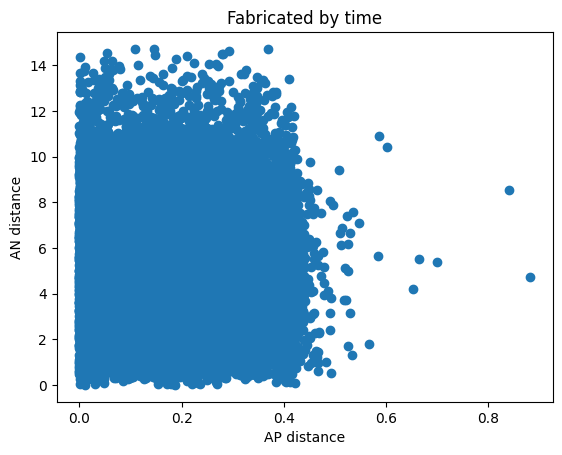

In [13]:
plt.scatter(ap_dist, an_dist)
# plt.yscale('log')
# plt.xscale('log')
plt.xlabel('AP distance')
plt.ylabel('AN distance')
plt.title('Fabricated by time')

# Neural Network Architeinput_anchor = tf.keras.layers.Input(shape=(ANTENNACOUNT * ANTENNACOUNT,))
input_positive = tf.keras.layers.Input(shape=(ANTENNACOUNT * ANTENNACOUNT,))
input_negative = tf.keras.layers.Input(shape=(ANTENNACOUNT * ANTENNACOUNT,))

embedding_anchor = embedding_model(input_anchor)
embedding_positive = embedding_model(input_positive)
embedding_negative = embedding_model(input_negative)

output = tf.keras.layers.concatenate([embedding_anchor, embedding_positive, embedding_negative], axis=1)
model = tf.keras.models.Model([input_anchor, input_positive, input_negative], output)cture

In [ ]:
CC_DIMENSIONALITY = 2
embedding_model = tf.keras.models.Sequential(
	[
		tf.keras.layers.Dense(ANTENNACOUNT * ANTENNACOUNT, activation = "relu", input_shape = (ANTENNACOUNT * ANTENNACOUNT,)),
		tf.keras.layers.BatchNormalization(),
		tf.keras.layers.Dense(512, activation = "relu"),
		tf.keras.layers.BatchNormalization(),
		tf.keras.layers.Dense(256, activation = "relu"),
		tf.keras.layers.BatchNormalization(),
		tf.keras.layers.Dense(128, activation = "relu"),
		tf.keras.layers.BatchNormalization(),
		tf.keras.layers.Dense(64, activation = "relu"),
		tf.keras.layers.BatchNormalization(),
		tf.keras.layers.Dense(CC_DIMENSIONALITY, activation = "linear"),
	]
)

In [ ]:
input_anchor = tf.keras.layers.Input(shape=(ANTENNACOUNT * ANTENNACOUNT,))
input_positive = tf.keras.layers.Input(shape=(ANTENNACOUNT * ANTENNACOUNT,))
input_negative = tf.keras.layers.Input(shape=(ANTENNACOUNT * ANTENNACOUNT,))

embedding_anchor = embedding_model(input_anchor)
embedding_positive = embedding_model(input_positive)
embedding_negative = embedding_model(input_negative)

output = tf.keras.layers.concatenate([embedding_anchor, embedding_positive, embedding_negative], axis=1)
model = tf.keras.models.Model([input_anchor, input_positive, input_negative], output)

# Neural Network Training

In [ ]:
optimizer = tf.keras.optimizers.Adam()
model.compile(loss = triplet_loss, optimizer = optimizer)

batch_size = 8192
learning_rates = [1e-3, 1e-3, 1e-4, 1e-4, 1e-5, 1e-5, 1e-5, 1e-5]
T_c = 5

for l in range(len(learning_rates)):
	print("\nTraining Session ", l + 1, "\nT_c =", T_c)
	triplets = generate_triplets(150000, T_c)
	optimizer.learning_rate.assign(learning_rates[l])
	print("\nBatch Size: ", batch_size, "\nEpochs: ", 10, "\nLearning rate: ", learning_rates[l])
	model.fit(triplets, triplets, batch_size = batch_size, steps_per_epoch = int(len(triplets[0]) / batch_size), epochs = 10)

# Plotting the Channel Chart

In [ ]:
channel_chart_positions = []
	
for csi, pos, timestamp in training_set.batch(1000):
	channel_chart_positions.append(embedding_model.predict(csi))

channel_chart_positions = np.vstack(channel_chart_positions)

plot_colorized(channel_chart_positions, title = "Channel Chart")

# Performance Evaluation

In [ ]:
from sklearn.metrics import pairwise_distances
from sklearn.neighbors import NearestNeighbors
from sklearn import manifold
import random

# Continuity is identical to trustworthiness, except that original space and embedding space are flipped
def continuity(*args, **kwargs):
    args = list(args)
    args[0], args[1] = args[1], args[0]
    return manifold.trustworthiness(*args, **kwargs)

def kruskal_stress(X, X_embedded, *, metric="euclidean"):
	dist_X = pairwise_distances(X, metric = metric)
	dist_X_embedded = pairwise_distances(X_embedded, metric = metric)
	beta = np.divide(np.sum(dist_X * dist_X_embedded), np.sum(dist_X_embedded * dist_X_embedded))

	return np.sqrt(np.divide(np.sum(np.square((dist_X - beta * dist_X_embedded))), np.sum(dist_X * dist_X)))

In [ ]:
subset_indices = random.sample(range(len(groundtruth_positions)), len(groundtruth_positions) // 10)

groundtruth_positions_subset = groundtruth_positions[subset_indices]
channel_chart_positions_subset = channel_chart_positions[subset_indices]

ct_train = continuity(groundtruth_positions_subset, channel_chart_positions_subset, n_neighbors = int(0.05 * len(groundtruth_positions_subset)))
tw_train = manifold.trustworthiness(groundtruth_positions_subset, channel_chart_positions_subset, n_neighbors = int(0.05 * len(groundtruth_positions_subset)))
ks_train = kruskal_stress(groundtruth_positions_subset, channel_chart_positions_subset)

metrics_channel_chart_train = np.around(np.array([ct_train, tw_train, ks_train]), 4)

print("CT: {} \nTW: {} \nKS: {}".format(*metrics_channel_chart_train))